In [1]:
import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.cm as cm
import cartopy.mpl.ticker as cticker
import matplotlib.colors as mcolors
import pickle

import os
    
plotdir = './plots/precip/'
if not os.path.exists(plotdir):
    os.makedirs(plotdir)  

In [3]:
# THIS STEP IS ONLY NECESSARY IF PICKLE IS NOT USED!!

exp_list  = ["IMERG","4km_fesom","ifs_cycle2_4km_tp","9km_fesom","ifs_cycle2_3km_tp"]
expid_list= ["","hzfy","hqys","hz9o","hr0n"]

# give IFS resolution only, FESOM/NEMO don't change from 25/5km
array_labels   = ["GPM IMERG","Cycle 3, 4.4km, IFS-FESOM","Cycle 2, 4.4km, IFS-FESOM","Cycle 3, 9km, IFS-FESOM","Cycle 2, 2.8km, IFS-FESOM"]
array_linestyle= ["","solid","dashed","solid","dashed"]

data = {}
lat = {}
lon = {}


array_var = ["precip"]

tstep = 285

for (e,exp),expid in zip(enumerate(exp_list),expid_list): 
        print(e)
        
        if exp_list[e] != "IMERG":
            if  array_linestyle[e] == "solid": 
              file=f'/work/bm1235/u233156/IFS_cycle3/{exp}/{expid}_2D_precip_hourly_remap_0.1x0.1_202001_tropics.nc'
              ds = xr.open_dataset(file,engine='netcdf4')['tp'].load()
              ds.values = ds.values
              data[e] = ds[tstep, :, :]
              lon[e]=np.linspace(0,359.9,3600)
              lat[e]=np.linspace(30,-30,601)
            else:
              file=f'/work/bm1235/u233156/IFS_cycle2/tp_mmperd_{expid}_alltimes_remap_0.1x0.1_tropics_202001.nc'
              ds = xr.open_dataset(file,engine='netcdf4')['var228'].load()
              ds.values = ds.values /24 #from mm/d to mm/h
              data[e] = ds[tstep, :, :]
              lon[e]=np.linspace(-180,179.9,3600)
              lat[e]=np.linspace(30,-30,601)

        else:    
            file=f'/work/bm1235/u233156/observations/GPM_IMERG/GPM_IMERG_hourly_2020_01_20to31_Pacific_ITCZ.nc'
            in_GPM = xr.open_dataset(file,engine='netcdf4')['precipitationCal'].load()
            data[e] = in_GPM[tstep, :, :] 
            lon[e]=np.linspace(155.05,274.95,1200)
            lat[e]=np.linspace(-1.95,12.95,150) 
            
# WRITE PICKLE

# Open a file and use dump()
with open('../data/map_precip_tstep_NextGEMS_Cycle2_Cycle3_PacificOcean_remap0.1deg_3hourly.pickle', 'wb') as file:
      
    # A new file will be created
    pickle.dump([data,lon,lat], file)  

0
1
2
3
4


In [2]:
# CONTINUE HERE IF PICKLE IS USED

with open(f'../data/map_precip_tstep_NextGEMS_Cycle2_Cycle3_PacificOcean_remap0.1deg_3hourly.pickle', 'rb') as file:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    data,lon,lat = pickle.load(file)

0
1
2
3
4


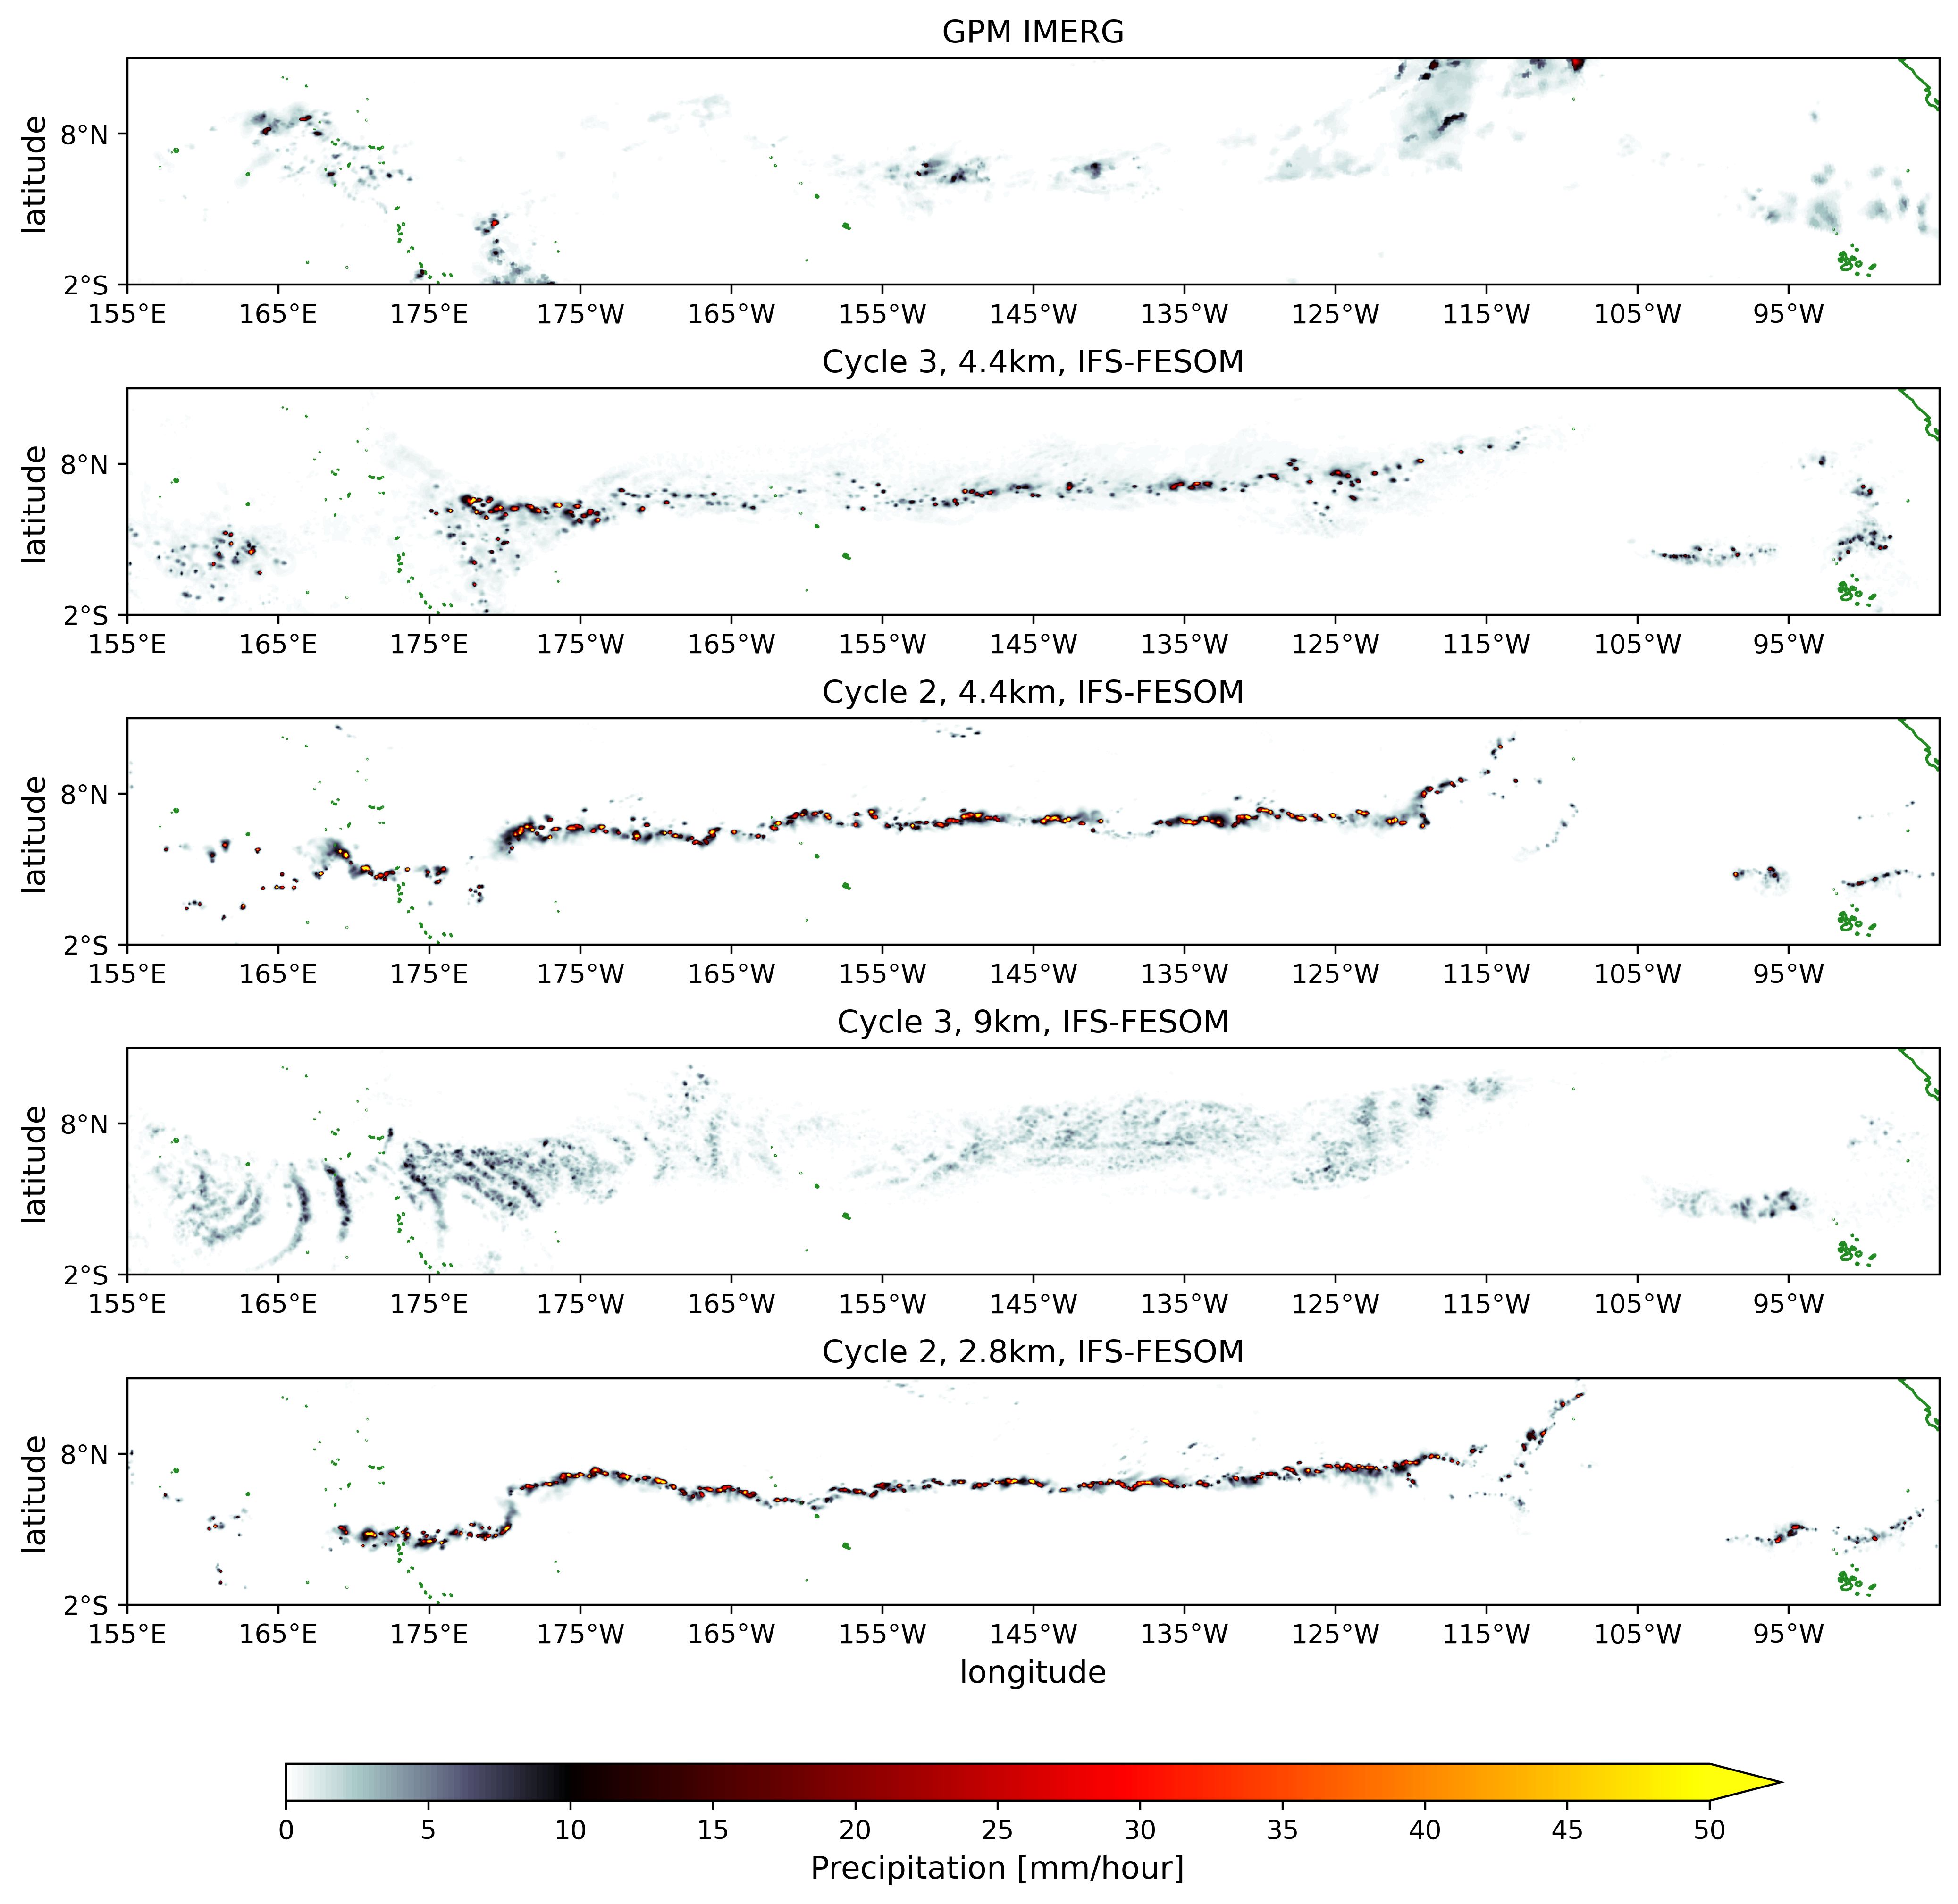

In [4]:
exp_list  = ["IMERG","4km_fesom","ifs_cycle2_4km_tp","9km_fesom","ifs_cycle2_3km_tp"]
expid_list= ["","hzfy","hqys","hz9o","hr0n"]

# give IFS resolution only, FESOM/NEMO don't change from 25/5km
array_labels   = ["GPM IMERG","Cycle 3, 4.4km, IFS-FESOM","Cycle 2, 4.4km, IFS-FESOM","Cycle 3, 9km, IFS-FESOM","Cycle 2, 2.8km, IFS-FESOM"]
array_linestyle= ["","solid","dashed","solid","dashed"]

min_lat  = -2
max_lat  = 13 
min_lon  = 155
max_lon  = 275


# sample the colormaps that you want to use. Use 128 from each so we get 256
# colors in total
colors1_temp = plt.cm.bone.reversed()
colors1 = colors1_temp(np.linspace(0, 1, 100))
colors2 = plt.cm.hot(np.linspace(0, 1, 530))

# combine them and build a new colormap
colors = np.vstack((colors1[0:100], colors2[0:400]))
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)




# Define title strings

fig, ax = plt.subplots(nrows=5,ncols=1,dpi=400,
                        subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)},figsize=(12,13))

axes = ax.flatten()

for e in range(len(exp_list)):
        print(e)
        
        extent = [min_lon, max_lon, min_lat, max_lat] 
        axes[e].set_extent(extent, crs=ccrs.PlateCarree())  
        cnf = axes[e].contourf(lon[e],lat[e],data[e],transform = ccrs.PlateCarree(),cmap=mymap,extend='max',levels = np.linspace(0,50,501))


    
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.2)
cbar1_ax = fig.add_axes([0.17, 0.18, 0.66, 0.015],autoscalex_on=True)
#cbar2_ax = fig.add_axes([0.92, 0.15, 0.01, 0.3])
cbar1=fig.colorbar(cnf, cax=cbar1_ax,orientation='horizontal',ticks=np.linspace(0,50,11))
cbar1.set_label('Precipitation [mm/hour]',fontsize=12)

#cbar2=fig.colorbar(p2, cax=cbar2_ax,orientation='vertical')
for ie in range(len(axes)):
    axes[ie].coastlines(color='forestgreen')
    axes[ie].set_xticks(np.arange(min_lon,max_lon,10), crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    axes[ie].xaxis.set_major_formatter(lon_formatter)

    axes[ie].set_yticks(np.arange(min_lat,max_lat,10), crs=ccrs.PlateCarree())
    lat_formatter = cticker.LatitudeFormatter()
    axes[ie].yaxis.set_major_formatter(lat_formatter)
    axes[ie].set_title(array_labels[ie])
    
    axes[ie].set_ylabel('latitude',fontsize=12)
axes[len(axes)-1].set_xlabel('longitude',fontsize=12)     
        
plt.savefig(plotdir + 'map_precip_tstep_NextGEMS_Cycle2_Cycle3_Pacific_ITCZ_remap0.1deg_3hourly_overview_paper_20200131_21UTC.png')